# Data and Statistical Calibration (Indirect Inference) on Model

### Timothy Kam and Junsang Lee

GitHub project site: https://github.com/phantomachine/csim

In [1]:
import requests, zipfile, io
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import os
from fredapi import Fred
from scipy import interpolate
# from seasonal import fit_seasons, adjust_seasons

%matplotlib inline

# Purpose

This notebook documents the steps we used to construct:

1. External calibration of model's annual discount factor (model is quarterly so model's solution is based on quarterly version) using ex-post Fisher relation on observed data:
    
    * T-Bill Rate (3-month) as proxy for a short rate (annual), $i$
    
    * GDP Deflator inflation rate as proxy for inflation (annual), $\pi$
    
2. Data mean of $M1/GDP$

    * Lucas and Nicolini's (JME, 2015) ``New M1`` series is used.
    
3. Spline-fitted relation between $M1/GDP$ and $i$ to obtain a point estimate of the elasticity of $M1/GDP$ w.r.t. $i$

    * Note: the spline-fitted model on the data is just an arbitrary auxiliary statistical model for indirect inference on our theory-implied elasticity.
   

# Annual Data


We get our data series, obtained from Minneapolis Fed Working Paper 718, *On the Stability of Money Demand*, by Robert E Lucas, Jr. and Juan Pablo Nicolini, at:

https://www.minneapolisfed.org/research/working-papers/on-the-stability-of-money-demand

**Note**: this paper was published in the [*Journal of Monetary Economics* (Vol. 73, July 2015, pp. 48-65)](http://dx.doi.org/10.1016/j.jmoneco.2015.03.005) 

In [2]:
# Note: 
# (1) The ! command below, escapes you from the current Python interface to the server Terminal prompt
# (2) pip install will install a new python package/library that may not be pre-existing already
# !pip install fredapi # uncomment and run if FRED API not installed yet

# Instantiate Fred class as "fred", use your own api_key!
fred = Fred(api_key='8f21f53dd9e218b356ed31f6aa39b26d')

In [3]:
# URL to data in ZIP format
url = "http://minneapolisfed.contentdm.oclc.org/utils/getdownloaditem/collection/p16030coll7/id/91/filename/92.zip"
zipf = requests.get(url)
file = zipfile.ZipFile(io.BytesIO(zipf.content))
file.extractall()

In [4]:
# View directory
!ls -la

total 7384
drwxr-xr-x 5 obiwan obiwan    4096 Oct 16 15:49  .
drwxrwxr-x 5 obiwan obiwan    4096 Oct  6 16:55  ..
drwxr-xr-x 4 obiwan obiwan    4096 Jul 18 09:03  AdditionalFiles
-rw-rw-r-- 1 obiwan obiwan  465156 Jul 25 11:39  data_notes-lucas-nicolini-annual.html
-rw-rw-r-- 1 obiwan obiwan  200526 Oct 16 15:49  data_notes-lucas-nicolini-annual.ipynb
-rw-rw-r-- 1 obiwan obiwan  382751 Jul 19 11:07  data_notes-lucas-nicolini.html
-rw-rw-r-- 1 obiwan obiwan  154424 Oct 15 15:40  data_notes-lucas-nicolini-quarterly.ipynb
drwxr-xr-x 2 obiwan obiwan    4096 Jul 19 11:38  .ipynb_checkpoints
-rw-r--r-- 1 obiwan obiwan      78 Jul 19 11:40  .~lock.MoneyData_Lucas-Nicolini-Wang-Wright-Liu-version.xlsx#
-rw------- 1 obiwan obiwan  607291 Jul 17 09:10 'Long-run money demand redux _ VOX, CEPR Policy Portal.pdf'
-rw-rw-r-- 1 obiwan obiwan  590222 Jul 17 09:33  Lucas-Nicolini-Money-Demand-JME2015.pdf
-rw-rw-r-- 1 obiwan obiwan   17370 Jul 19 11:39  MoneyData_Lucas-Nicolini-Wang-Wright-Liu-version.x

In [5]:
# Probe inside AdditionalFiles (from Lucas and Nicolini)
f = os.listdir("AdditionalFiles/data/")
print(f)

['.~lock.data_consolidated.xlsx#', 'AppendixMMDA.pdf', 'Quarterly_mmda.xlsx', 'data_consolidated.xlsx']


In [6]:
# Note: 
# (1) The ! command below, escapes you from the current Python interface to the server Terminal prompt
# (2) pip install will install a new python package/library that may not be pre-existing already
# !pip install fredapi # uncomment and run if FRED API not installed yet

# Instantiate Fred class as "fred", use your own api_key!
fred = Fred(api_key='8f21f53dd9e218b356ed31f6aa39b26d')

In [7]:
# Create empty dictionary
df = {}

In [8]:
# Import Lucas-Nicolini (2015, JME) dataset (Annual version)

# from RATES excel tab
data_lucas_nicolini_rates = pd.read_excel('AdditionalFiles/data/data_consolidated.xlsx', 'RATES')

# from data_consolidated tab
data_lucas_nicolini_m1sweep = pd.read_excel('AdditionalFiles/data/data_consolidated.xlsx','data_consolidated')

# from ASSETS tab
data_lucas_nicolini_gdp = pd.read_excel('AdditionalFiles/data/data_consolidated.xlsx', 'ASSETS')

In [9]:
# Store lists of data series and KEYs into dictionary df
df['Dates'] = data_lucas_nicolini_gdp['YEAR'].tolist()
df['T-Bill Rate (3-month, annual)'] = data_lucas_nicolini_rates['tbills3m'].tolist()
df['New M1 (annual)'] = data_lucas_nicolini_m1sweep['new_m1'].tolist()
df['GDP (Nominal, annual)'] = data_lucas_nicolini_gdp['GDP'].tolist()
nM1 = df['New M1 (annual)']
gdp = df['GDP (Nominal, annual)']
df['NewM1/GDP'] = [ nM1[i]/gdp[i] for i in range(len(nM1)) ]

obslength = []
keys = []
for list_idx, list_key in enumerate(df):
    list_length = len(df[list_key])
    print(list_idx, list_key, "> Observations:", list_length)
    obslength.append(list_length)
    keys.append(list_key)
obslength_min = min(obslength)
print("Shortest data series is %s with data length of %i" %(keys[obslength==obslength_min], obslength_min))

0 Dates > Observations: 102
1 T-Bill Rate (3-month, annual) > Observations: 96
2 New M1 (annual) > Observations: 98
3 GDP (Nominal, annual) > Observations: 102
4 NewM1/GDP > Observations: 98
Shortest data series is Dates with data length of 96


In [10]:
# Truncate longer series to have the same length of: obslength_min
for list_idx, list_key in enumerate(df):
    df[list_key] = df[list_key][0:obslength_min]

In [11]:
# Convert df to Pandas dataframe
d = pd.DataFrame(df)
d = d.set_index(d['Dates'])

In [12]:
# Truncate data window
date_truncate_start = '1915'
date_truncate_stop = '2007'

dcut = d.loc[date_truncate_start:date_truncate_stop]

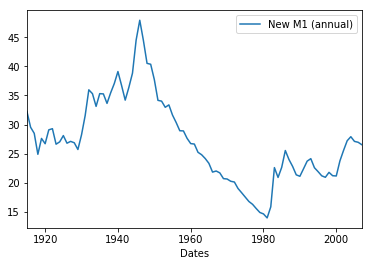

In [13]:
# Sweep adjusted M1 (M1S)
dcut.plot(y='New M1 (annual)')

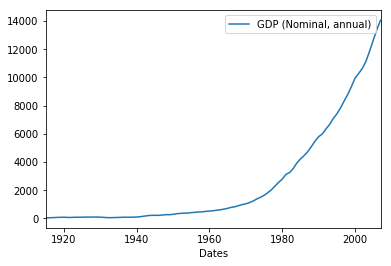

In [14]:
# Nominal GDP
dcut.plot(y='GDP (Nominal, annual)')

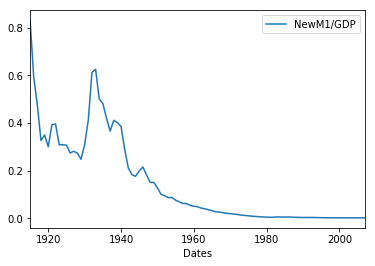

In [15]:
# M/PY using M1 (sweep adjusted) data for M, nominal GDP for PY
dcut.plot(y='NewM1/GDP')

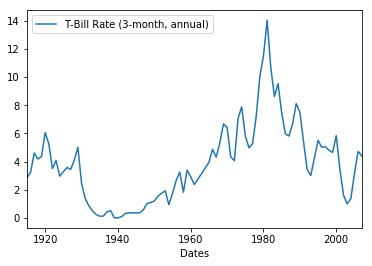

In [16]:
# T-Bill Rate (3-month, annual) := r
dcut.plot(y='T-Bill Rate (3-month, annual)')

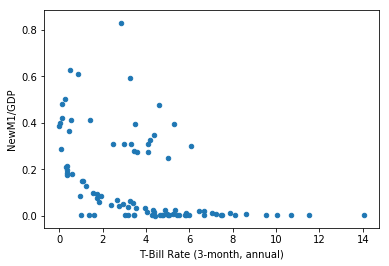

In [17]:
# Scatter plot M/PY vs. r
dcut.plot(x='T-Bill Rate (3-month, annual)', y='NewM1/GDP', kind='scatter')

In [18]:
# Full sample stats
dcut.mean()

Dates                            1961.000000
GDP (Nominal, annual)            2581.647731
New M1 (annual)                    27.180772
NewM1/GDP                           0.147899
T-Bill Rate (3-month, annual)       3.854204
dtype: float64

## Truncated data (1948-2007) (FRED's GDP deflator inflation rate and Lucas-Nicolini)

We use the sample from 1948 to 2007 only for external calibration of $\beta$ below. 

In [19]:
# Add data from FRED and KEY to dictionary
df_comb = fred.get_series('GNPDEF', frequency='a')
df_comb = df_comb.reset_index()
df_comb.columns = ['Dates', 'GDP Deflator']
df_comb = df_comb.set_index(df_comb['Dates'])
# df_fred = df_fred.diff(periods=1, axis=0)[1::]
df_comb['Inflation (GDP Deflator)'] = df_comb['GDP Deflator']/df_comb['GDP Deflator'].shift(1) - 1
df_comb = df_comb.loc['1947-01-01':'2007-01-01']

# Add data from Lucas-Nicolini (GDP Deflator inflation)
df_comb['T-bill Rate (3-month)'] = (dcut.loc['1947':'2007', 'T-Bill Rate (3-month, annual)']/100.).tolist()
df_comb['GDP'] = (dcut.loc['1947':'2007', 'GDP (Nominal, annual)']).tolist()
df_comb['New M1'] = (dcut.loc['1947':'2007', 'New M1 (annual)']).tolist()
df_comb['NewM1/GDP'] = (dcut.loc['1947':'2007', 'NewM1/GDP']).tolist()
df_comb = df_comb

In [20]:
# From first obs (since first-differencing GDP deflator loses one initial data point)
df_comb = df_comb.dropna(axis='rows')
df_comb

,Dates,GDP Deflator,Inflation (GDP Deflator),T-bill Rate (3-month),GDP,New M1,NewM1/GDP
Dates,,,,,,,
1948-01-01,1948-01-01,12.927,0.056127,0.01040,269.1,40.509104,0.150536
1949-01-01,1949-01-01,12.906,-0.001625,0.01102,267.2,40.351796,0.151017
1950-01-01,1950-01-01,13.059,0.011855,0.01218,293.7,37.725570,0.128449
1951-01-01,1951-01-01,13.989,0.071215,0.01552,339.3,34.155615,0.100665
1952-01-01,1952-01-01,14.232,0.017371,0.01766,358.3,34.018979,0.094946
1953-01-01,1953-01-01,14.406,0.012226,0.01931,379.3,32.963354,0.086906
1954-01-01,1954-01-01,14.539,0.009232,0.00953,380.4,33.375394,0.087738
1955-01-01,1955-01-01,14.785,0.016920,0.01753,414.7,31.620449,0.076249
1956-01-01,1956-01-01,15.289,0.034089,0.02658,437.4,30.349794,0.069387


### Robustness: Data from FRED (CPI inflation) combined with Lucas-Nicolini

If we want to use a longer data series for inflation to match up with the rest of the Lucas-Nicolini data series starting from 1915, then we'll have to construct inflation using CPI data from 1915. This section shows that this series co-moves with the GDP deflator closely for the overlapping sample periods from 1948 to 2007.

In [21]:
# Series from FRED: CPIAUCNS
# Add data from FRED and KEY to dictionary
df_comb2 = fred.get_series('CPIAUCNS', frequency='a')
df_comb2 = df_comb2.reset_index()
df_comb2.columns = ['Dates', 'CPI (seasonal)']
df_comb2 = df_comb2.set_index(df_comb2['Dates'])


start_year = '1915'
stop_year = '2007'# '2007'
df_comb2['Inflation (CPI, raw)'] = df_comb2['CPI (seasonal)']/df_comb2['CPI (seasonal)'].shift(1) - 1
df_comb2 = df_comb2.loc[start_year+'-01-01':stop_year+'-01-01']


# Add data from Lucas-Nicolini (GDP Deflator inflation)
df_comb2['T-bill Rate (3-month)'] = (dcut.loc[start_year:stop_year, 'T-Bill Rate (3-month, annual)']/100.).tolist()
df_comb2['GDP'] = (dcut.loc[start_year:stop_year, 'GDP (Nominal, annual)']).tolist()
df_comb2['New M1'] = (dcut.loc[start_year:stop_year, 'New M1 (annual)']).tolist()
df_comb2['NewM1/GDP'] = (dcut.loc[start_year:stop_year, 'NewM1/GDP']).tolist()

# From first obs (since first-differencing GDP deflator loses one initial data point)
df_comb2 = df_comb2.dropna(axis='rows')

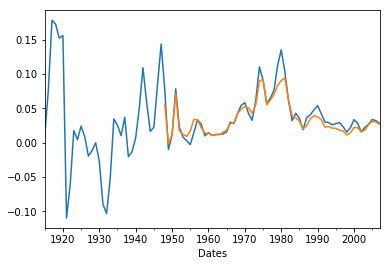

In [22]:
# Visually check if OK (i.e., "reasonable") to use CPI inflation instead of GDP-deflator inflation
df_comb2['Inflation (CPI, raw)'].plot()
df_comb['Inflation (GDP Deflator)'].plot()

In our calibrations below, we will externally calibrate $\beta$ using the T-Bill (3-month) rate and the CPI growth rate for data stored above in the subset of ``df_comb2`` Thus we will ignore this GDP-deflator inflation series.

# Using spline basis functions to fit money demand ($M1/GDP$ vs $i$)

In [23]:
y = df_comb2['NewM1/GDP'].tolist()
x = df_comb2['T-bill Rate (3-month)'].tolist()
data = np.asarray(sorted(zip(x,y)))
L_fit = interpolate.splrep(data[:,0], data[:,1], s=3)

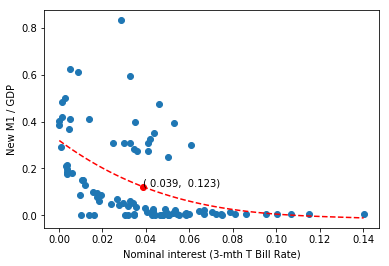

In [24]:
# Scatter plot data
plt.plot(x, y, 'o')
# Plot fitted spline function 
i_set = np.linspace(data[:,0].min(), data[:,0].max())
L_set = interpolate.splev(i_set, L_fit, der=0)
plt.plot(i_set, L_set, '--r')
# Plot point where data at mean
i_mean = np.asarray(x).mean()
L_mean = interpolate.splev(i_mean, L_fit, der=0)
# L_mean = df_comb2['NewM1/GDP'].mean()
L_mean_slope = interpolate.splev(i_mean, L_fit, der=1)
plt.plot(i_mean, L_mean, 'or')
# plt.text(i_mean, L_mean, "(" + str(i_mean) +"," + str(L_mean) + ")")
plt.text(i_mean, L_mean, "(%6.3f, %6.3f)" % (i_mean, L_mean))
plt.xlabel("Nominal interest (3-mth T Bill Rate)")
plt.ylabel("New M1 / GDP")
plt.show()

**Note**: The red dot corresponds to the fitted value of $M1/GDP$ at the sample mean of nominal interest rate.

In [25]:
Elasticity_L_i = L_mean_slope*i_mean/L_mean
print("L_mean = %6.4f" %(L_mean))
print("i_mean = %6.4f" %(i_mean))
print("Slope = %6.4f" %(L_mean_slope))
print("Elasticity of M1/GDP w.r.t. Nominal Interest Rate = %6.4f" %(Elasticity_L_i) )

L_mean = 0.1226
i_mean = 0.0385
Slope = -3.5883
Elasticity of M1/GDP w.r.t. Nominal Interest Rate = -1.1279


In [26]:
# Show data means
print("Mean in Annual Data:\n")
df_comb2.mean()

Mean in Annual Data:



CPI (seasonal)             61.693871
Inflation (CPI, raw)        0.034330
T-bill Rate (3-month)       0.038542
GDP                      2581.647731
New M1                     27.180772
NewM1/GDP                   0.147899
dtype: float64

# Hand calculation from model's Stationary Monetary Equilibrium

## For calibrating $\beta$ (1915-2007)

Ex post Fisher relation gives us
$$
(1+r) = \frac{1+i}{1+\pi}
$$
where
* $r$, real interest rate
* $i$, nominal interest rate
* $\pi$, inflation rate

In a stationary equilibrium in the model, we have $\beta = 1/(1+r)$. So we can relate $\beta$ to long run average in data as:
$$
\beta = \frac{1+\pi}{1+i}
$$

In [27]:
# Nominal interest rate
i = df_comb2['T-bill Rate (3-month)'].tolist()
ibar = np.asarray(i).mean()
# Inflation rate
pi = df_comb2['Inflation (CPI, raw)'].tolist()
pibar = np.asarray(pi).mean()
# Compute BETA
beta = (1.0 + pibar)/(1.0 + ibar)
print("BETA = %0.5g" % (beta))

BETA = 0.99594


## Model's stationary equilibrium elasticity

Getting elasticity of M1/GDP w.r.t. i:
$$
\eta_i := \frac{d (M1/GDP)}{di}\frac{\bar{i}}{\bar{M1/GDP}} = \frac{\partial (M1/GDP)}{\partial \pi} \frac{d\pi}{di}\frac{\bar{i}}{\bar{M1/GDP}}
$$
And set
$$
\frac{d\pi}{di} = \beta
$$

since Fisher relation says $\pi = \beta (1+i) - 1$.

In [28]:
# M1/GDP ratio from model equilibrium. Already Annualized in CALIBRATE.PY: Q freq --> A freq
M1GDPbar = 0.188160
# Numerical gradient of M1/GDP wrt inflation rate. Annualized: Q freq --> A freq
slope_M1GDP_pi = -0.447899 #-0.359968
slope_M1GDP_pi = slope_M1GDP_pi*16.0

# Elasticity
ETA = slope_M1GDP_pi*beta*(ibar/M1GDPbar)
print("Model implied elasticity of M1/GDP w.r.t. i = %6.4f" % (ETA))

Model implied elasticity of M1/GDP w.r.t. i = -1.4620


# Summary

We did the following:

* For fixed model parameters $(\bar{U}_{DM}, \kappa, \chi)$ we can generated annualized measures of average hours worked and M1/GDP ratio; and we also compute implied point-elasticity of $M1/GDP$ w.r.t. $i$, within an $\epsilon$-neighborhood of model solved at the data's average inflation and interest rates.

* Model parameters $(\bar{U}_{DM}, \kappa, \chi)$ are searched to make them as close as possible to the data avarages for hours worked and M1/GDP ratio, and, as close as possible to the auxiliary spline-fit statistical model's elasticity of $M1/GDP$ w.r.t. $i$ (point elasticity at data means).

Here's the result:

In [29]:
rowlabels = ["Hours", "Mean M1/GDP", "Elasticity: (M1/GDP), i"]
matchabox_data = [ 1.0/3.0, df_comb2['NewM1/GDP'].mean(), Elasticity_L_i  ]
matchabox_model = [ 0.329899, M1GDPbar, ETA  ]
matcha_table = {    "Aux. Statistic": rowlabels,
                    "Data (M1)": matchabox_data,
                    "Model (Avg)": matchabox_model, 
               }
# Create dataframe
df_matcha = pd.DataFrame(data=matcha_table)
df_matcha

,Aux. Statistic,Data (M1),Model (Avg)
0,Hours,0.333333,0.329899
1,Mean M1/GDP,0.147899,0.188160
2,"Elasticity: (M1/GDP), i",-1.127899,-1.461983


Models parameters were
* ``chi=0.03`` (which implies ``CHI=0.029670``)
* ``UbarDM=407.7725``
* ``KAPPA=0.003997``

Fixed and normalized parameters

* ``A=1.0``

* ``UbarCM=1.00`` 

Model solved with (quarterly) inflation/money growth rate 

* ``TAU=0.008894``
